In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [3]:
df = pd.read_csv('data/KSD_RP.csv', index_col=0)

test_date = "2014-02-01T00:00:00.000"
train_idxs = (df["epoch"] < test_date).values
df_train = df[train_idxs]
df_test = df[np.invert(train_idxs)]
df_test_sgp4 = df_test[["sat_id", "epoch", "x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]]
df_test_ans = df_test[["sat_id", "x", "y", "z", "Vx", "Vy", "Vz"]]

n_sat = len(pd.unique(df_train["sat_id"]))
KSD_list = pd.unique(df_train["KSD"])
RP_list = pd.unique(df_train["RP"])

# LR

In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [5]:
# features columns 
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

# target variables columns 
target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

In [6]:
# Linear (Polynomial) Regression models
poly = PolynomialFeatures(2)

pred_lr = pd.DataFrame(columns=target_cols, index=df_test.index)
pred_lr["sat_id"] = df_test["sat_id"]

for sat_id in tqdm(range(n_sat)):
    
    train_idxs = df_train["sat_id"] == sat_id
    test_idxs = df_test_sgp4["sat_id"] == sat_id
    X_train = df_train.loc[train_idxs, feature_cols]
    y_train = df_train.loc[train_idxs, target_cols]
    X_test = df_test_sgp4.loc[test_idxs, feature_cols]
    
    model = LinearRegression(normalize=True).fit(X_train.values, y_train.values) 
    pred_lr.loc[test_idxs, target_cols] = model.predict(X_test.values)

100%|██████████| 225/225 [00:54<00:00,  3.40it/s]


# IDAO

In [7]:
pred_idao = pd.read_csv('data/submission_KSD_RP.csv', index_col='id')

In [8]:
pred_idao['sat_id'] = pred_lr['sat_id']

# Metrics

In [9]:
from metrics import smape_idao, idao_score, smape_new_vector_norm, mahalanobis_distance

In [10]:
def print_metrics(model_name, pred):
    print(f"\n{model_name}\n")
    print(f"IDAO score:  {idao_score(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE IDAO:  {smape_idao(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE new:   {smape_new_vector_norm(pred, df_test_ans)}")    
#     print(f"Mahalanobis: {mahalanobis_distance(pred, df_test_ans)}")

In [11]:
pred_sgp4 = df_test_sgp4.rename(
    columns=dict(zip(feature_cols, target_cols))).drop("epoch", axis=1)

print_metrics("Total SGP4", pred_sgp4)
print_metrics("Total LR", pred_lr)
print_metrics("Total IDAO", pred_idao)


Total SGP4

IDAO score:  37.324851755698354
SMAPE IDAO:  0.6267514824430165
SMAPE new:   0.39937790198419265

Total LR

IDAO score:  55.47998004668874
SMAPE IDAO:  0.44520019953311263
SMAPE new:   0.31450244317893367

Total IDAO

IDAO score:  71.75312744274855
SMAPE IDAO:  0.2824687255725145
SMAPE new:   0.17220031261014032


# Graphs: metrics

In [12]:
def err(pred, ksd, rp, metric):
    sat_id = df[(df['KSD'] == ksd) & (df['RP'] == rp)]['sat_id'].values[0]
    p = pred[pred['sat_id'] == sat_id]
    a = df_test_ans[df_test_ans['sat_id'] == sat_id]
    if metric == "idao_score":
        return idao_score(p[target_cols], a[target_cols])
    elif metric == "smape_idao":
        return smape_idao(p[target_cols], a[target_cols])
    elif metric == "smape_new_vector_norm":
        return smape_new_vector_norm(p, a)
    elif metric == "mahalanobis_distance":
        return mahalanobis_distance(p, a)
    elif metric == "abs":
        return (p - a).abs()
    else:
        raise ValueError()

In [13]:
def plot_err(pred, pred_name, metric):
    plt.figure(figsize=(6,6))
    title = f'{pred_name}: {metric}'
    plt.title(title, fontsize=14)
    y_axis = True
    Z = np.empty((len(KSD_list), len(RP_list)))
    for i, ksd in enumerate(KSD_list):
        for j, rp in enumerate(RP_list):
            Z[len(KSD_list) - i - 1, j] = err(pred, ksd, rp, metric)
    im = plt.imshow(Z)
    plt.colorbar(im)
    plt.ylabel(f"КСД: {min(KSD_list):.2f} – {max(KSD_list):.2f} кв.м/кг")
    plt.xlabel(f"радиус перигея: {min(RP_list):.2f} – {max(RP_list):.2f} км")
    plt.xticks([])
    plt.yticks([])
#     plt.savefig(f"{title}.png")
    plt.show()

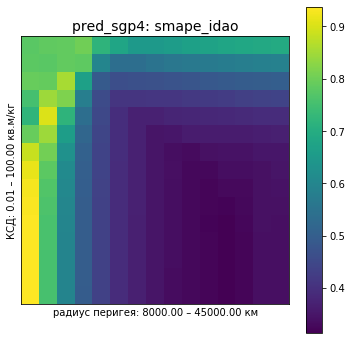

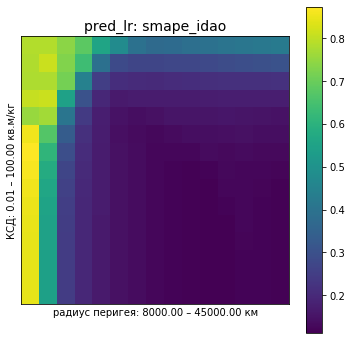

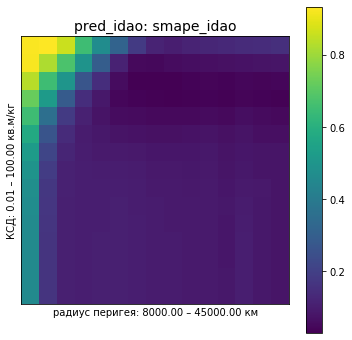

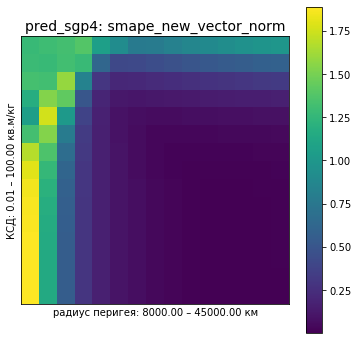

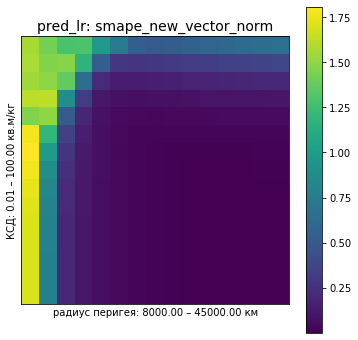

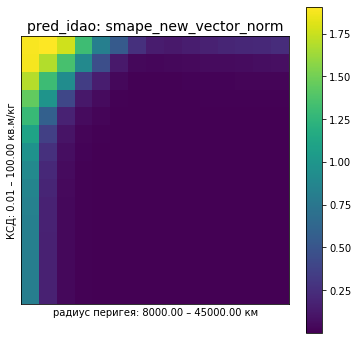

In [14]:
metric_list = [
    'smape_idao',
    "smape_new_vector_norm",
#     "mahalanobis_distance",
]
pred_dict = {
    "pred_sgp4": pred_sgp4, 
    "pred_lr": pred_lr, 
    "pred_idao": pred_idao,
}

for metric in metric_list:
    for pred_name, pred in pred_dict.items():
        plot_err(pred=pred, pred_name=pred_name, metric=metric) 


# Graphs: abs error

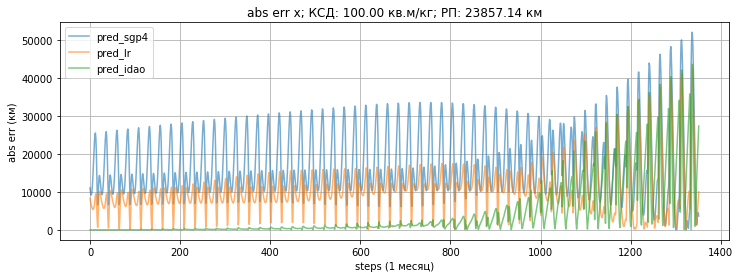

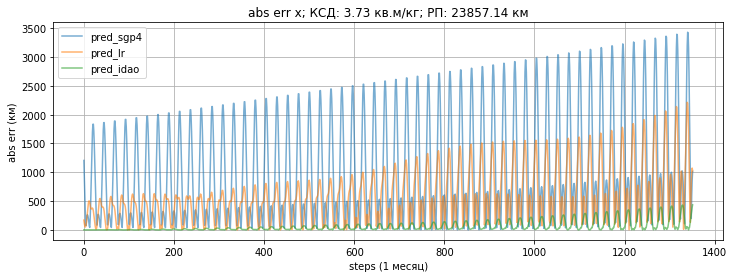

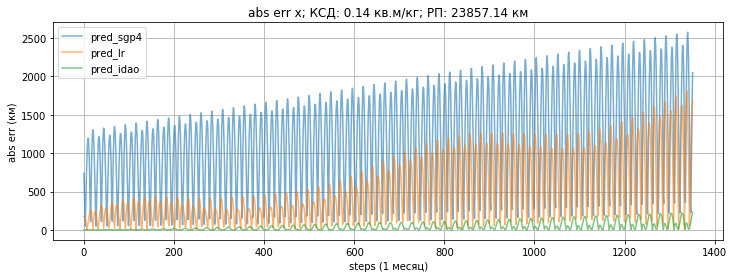

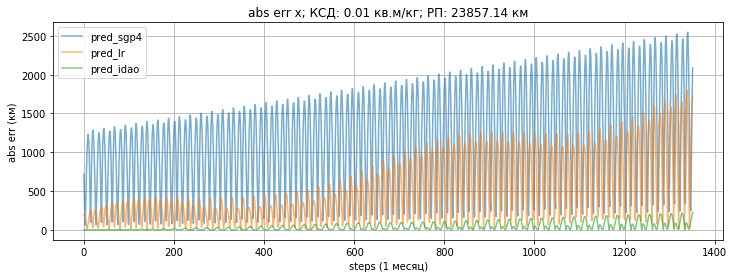

In [15]:
# для разных КСД при "среднем" РП
def plot_graph_err(preds=[pred_sgp4, pred_idao, pred_lr], ksd_graphs=list(KSD_list[::-5]) + [KSD_list[0]], rp=RP_list[6], coord='x'):
    for ksd in ksd_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

plot_graph_err()

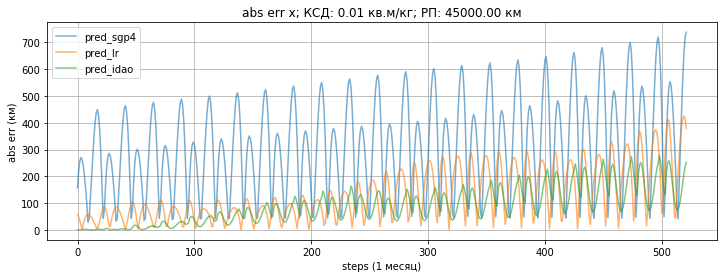

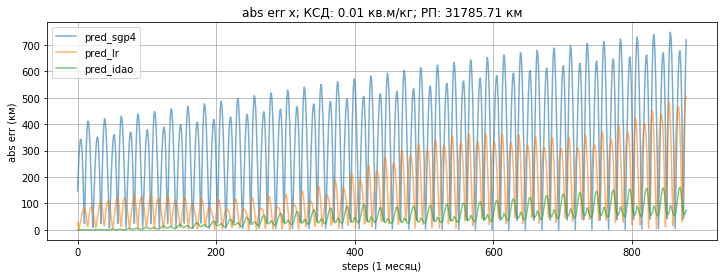

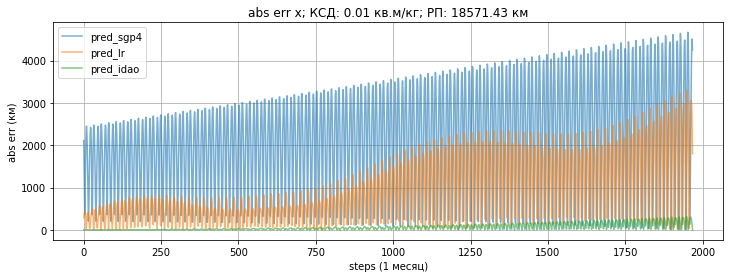

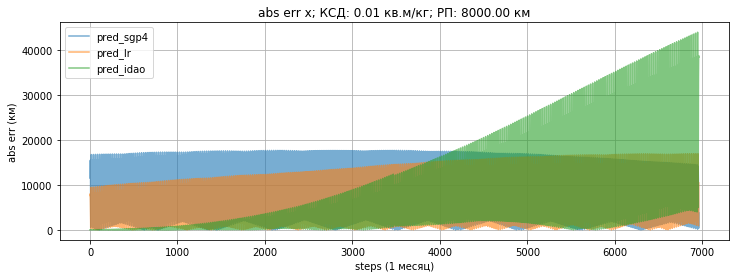

In [45]:
# для разных РП при "низком" КСД
def plot_graph_err(preds=[pred_sgp4, pred_idao, pred_lr], ksd=KSD_list[0], rp_graphs=list(RP_list[::-5]) + [RP_list[0]], coord='x'):
    for rp in rp_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

plot_graph_err()

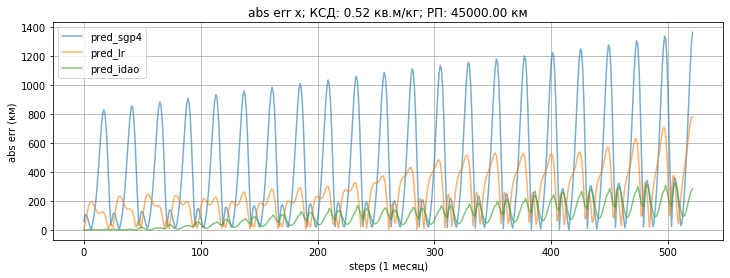

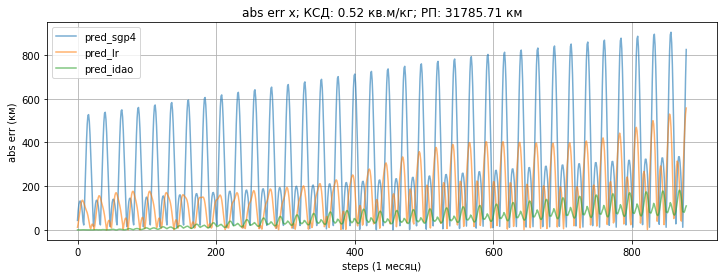

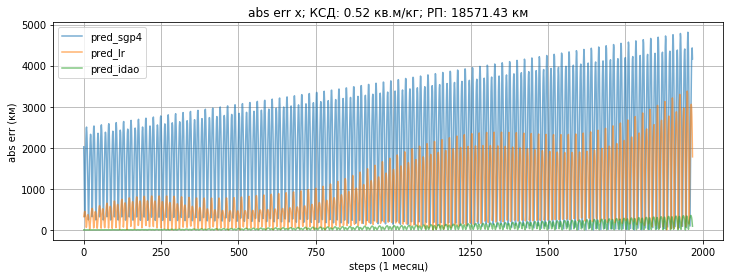

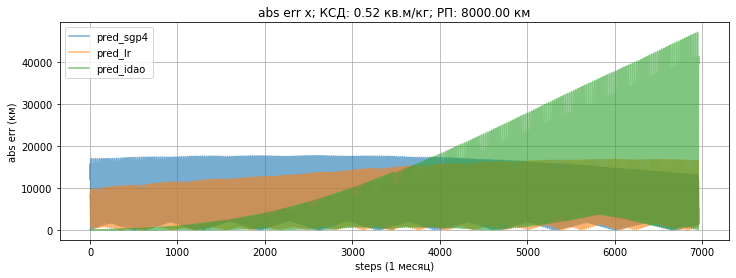

In [46]:
# для разных РП при "среднем" КСД
def plot_graph_err(preds=[pred_sgp4, pred_idao, pred_lr], ksd=KSD_list[6], rp_graphs=list(RP_list[::-5]) + [RP_list[0]], coord='x'):
    for rp in rp_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

plot_graph_err()

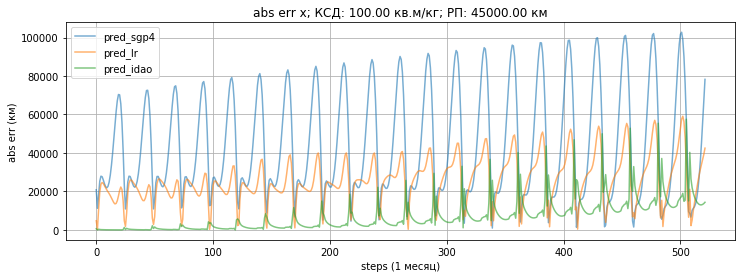

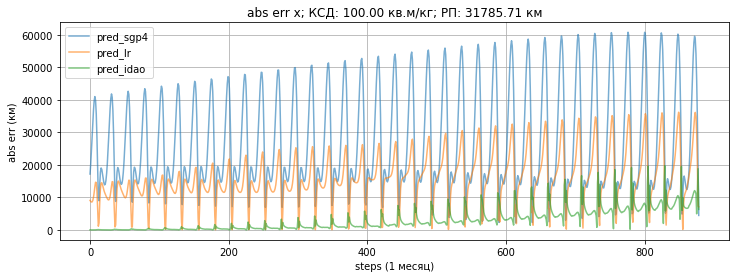

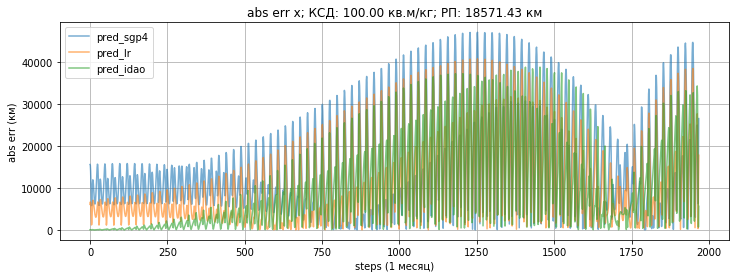

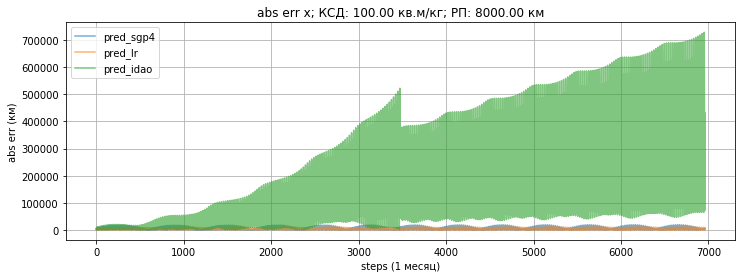

In [47]:
# для разных РП при "высоком" КСД
def plot_graph_err(preds=[pred_sgp4, pred_idao, pred_lr], ksd=KSD_list[-1], rp_graphs=list(RP_list[::-5]) + [RP_list[0]], coord='x'):
    for rp in rp_graphs: 
        plt.figure(figsize=(12,4))
        for pred_name, pred in pred_dict.items():
            plt.plot(err(pred, ksd, rp, metric="abs")[coord].values, alpha=0.6, label=pred_name)
        plt.grid()
        plt.xlabel('steps (1 месяц)')
        plt.ylabel('abs err (км)')
        title = f'abs err {coord}; КСД: {ksd:.2f} кв.м/кг; РП: {rp:.2f} км'
        plt.title(title)
        plt.legend()
#         plt.savefig(f"abs err {coord}; КСД: {ksd:.2f}; РП: {rp:.2f}.png")
        plt.show()

plot_graph_err()